In [60]:
from datetime import datetime, timedelta, date
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import os

In [61]:
sg = Subgrounds()
holders = sg.load_api('https://api.studio.thegraph.com/query/28103/token-holders/0.0.45')

In [62]:
"""
Fetches the snapshots for the given date range
"""
def do_snapshot_query(holders, start_date: datetime, finish_date: datetime):
    snapshot_query = holders.Query.tokenDailySnapshots(
        orderBy=holders.TokenDailySnapshot.date,
        orderDirection="desc",
        first=1000,
        where={
            "date_gte": start_date.strftime("%Y-%m-%d"),
            "date_lt": finish_date.strftime("%Y-%m-%d"),
            "token_": {
                "name": "gOHM",
            },
        }
    )

    results = sg.query_json([snapshot_query.date, snapshot_query.token.name, snapshot_query.balancesList])
    # [{"randomQueryKey": [{ <record one>}, { <record two> }, ...]}]
    results_query = results[0]
    return results_query.get(list(results_query.keys())[0])

start_date = datetime(2021,11,14)
finish_date = datetime(2021,12,3)
results = do_snapshot_query(holders, start_date, finish_date)

In [63]:
from itertools import islice

"""
Fetches the TokenHolderBalance records specified in the balances parameter
"""
def do_balances_query(holders, balances):
    # Split balances into arrays < 1000 records
    balances_iter = iter(balances)
    balances_chunks = list(iter(lambda: tuple(islice(balances_iter, 1000)), ()))

    df = pd.DataFrame()

    # Grab balances
    for chunk in balances_chunks:
        query = holders.Query.tokenHolderBalances(
            first=1000,
            where={
                "id_in": list(chunk)
            }
        )
#        print("query = ", query)

        results = sg.query_df([query.date, query.holder.holder, query.balance])
#        print("count = ", len(results))
        df = pd.concat([df, results])

    # Combine
    return df

balance_ids = []
for result in results:
    result_balance_ids = result.get("balancesList")
    balance_ids.extend(result_balance_ids)

# Format with 6 decimal places
pd.options.display.float_format = "{:.6f}".format

records = do_balances_query(holders, balance_ids)

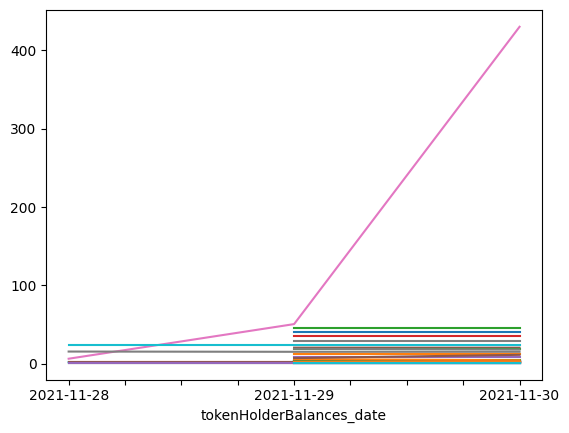

In [64]:
import matplotlib.pyplot as plt

filtered_records = records[records["tokenHolderBalances_balance"] >= 1]

filtered_records.pivot(index="tokenHolderBalances_date", columns="tokenHolderBalances_holder_holder", values="tokenHolderBalances_balance").plot(legend=False)

plt.show()